In [412]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Circular Billiards Table

## Process outline (WIP)

1. Define position and velocity of initial ball
2. Find where ball will hit the edge (parametrize line and iterate?)
3. Find normal line to border using derivative
4. Find angle between normal line and $e_1$; if in QI/III adjust by $\pi - \phi$
5. Rot, reflect, rot inv L 
6. Hit spot is new x and rot inv is new

$$ x = x_1 + t(x_2 - x_1) $$
$$ y = y_1 + t(y_2 - y_1) $$

Starting with a computational method rather than an analytical one to broaden perspective

In [413]:
#parametrization of line between p1 and p2-- input t in [0,1] to get [x,y]
def xy(t, p1, p2):
    x = p1[0] +  t*(p2[0]-p1[0])
    y = p1[1] +  t*(p2[1]-p1[1])
    return np.array([x,y])

#distance to boundary parametrized 
def param_boundary(t, x, v, boundary):
    return boundary(*xy(t, x, x + 2*v))

#reflect around line theta from x axis 
def R(theta):
    return np.array([[np.cos(theta)**2 - np.sin(theta)**2, 2*np.cos(theta)*np.sin(theta)],
             [2*np.cos(theta)*np.sin(theta), np.sin(theta)**2 - np.cos(theta)**2]])

In [414]:
#gives error in equation
#move all nonzero terms to one side 
#keep boundary within radius 1 
def circle(x,y):
    return np.abs(x**2 + y**2 - 1)

#return dy/dx
def d_circle(x,y):
    return (-1*x)/y

In [415]:
def ellipse(x,y):
    return np.abs((x**2)/2 + y**2 - 0.5)

#return dy/dx
def d_ellipse(x,y):
    return (x)/(-2*y)

In [416]:
#normalize
x = np.array([.1,.1])
v = np.array([1,0])
v = v/np.linalg.norm(v)

In [417]:
t_min = minimize(param_boundary, .5, args = (x, v, ellipse), bounds = ((.1,1),),method = 'Powell').x[0]
m = xy(t_min, x, x + 2*v)

In [418]:
m

array([0.98994949, 0.1       ])

In [419]:
# n = np.array([1, -1/d_circle(*m)])
# n /= np.linalg.norm(n)
# phi = np.arccos(np.dot(n, np.array([1,0])))
# print(n, '\n', phi)

In [420]:
n = np.array([1, -1/d_ellipse(*m)])
n /= np.linalg.norm(n)
phi = np.arccos(np.dot(n, np.array([1,0])))
if m[0]/m[1] < 0:
    print("adjusted")
    phi = np.pi - phi
print(n, '\n', phi)

[0.98019606 0.19802951] 
 0.19934720770440856


In [421]:
R(phi)

array([[ 0.92156863,  0.38821549],
       [ 0.38821549, -0.92156863]])

In [422]:
v_new = -np.matmul(R(phi), v)
v_new

array([-0.92156863, -0.38821549])

In [423]:
t_min = minimize(param_boundary, .2, args = (m, v_new, ellipse), bounds = ((.1,1),),method = 'Powell').x[0]
m_new = xy(t_min, m, m + 2*v_new)

In [424]:
# fig = plt.figure(figsize = (15,5))

# theta = np.linspace(0, 2*np.pi, 1000)
# plt.plot(np.cos(theta), np.sin(theta), color = 'black')
# plt.axis('equal')

# plt.plot([x[0], m[0]], [x[1], m[1]], color = 'red', ls = '--')
# plt.plot([m[0], m_new[0]], [m[1], m_new[1]], color = 'green', ls = 'dotted')

In [425]:
n

array([0.98019606, 0.19802951])

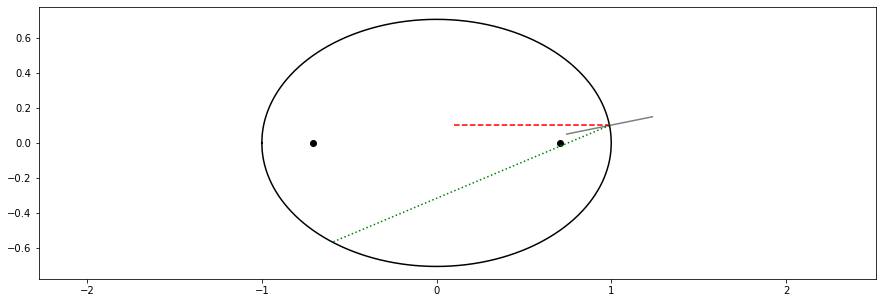

In [426]:
fig = plt.figure(figsize = (15,5))

a = np.linspace(-1, 1, 1000)
y_minus = -np.sqrt(1/2 - (a**2)/2)
y_plus = np.sqrt(1/2 - (a**2)/2)

plt.plot(np.concatenate([a,a[::-1]]), np.concatenate([y_minus,y_plus[::-1]]), color = 'black')
plt.axis('equal')

plt.plot([x[0], m[0]], [x[1], m[1]], color = 'red', ls = '--')
plt.plot([m[0], m_new[0]], [m[1], m_new[1]], color = 'green', ls = 'dotted')
plt.scatter(1/np.sqrt(2), 0, color = 'black')
plt.scatter(-1/np.sqrt(2), 0, color = 'black')

plt.plot([m[0]-n[0]/4, m[0], m[0]+n[0]/4, ], [m[1]-n[1]/4, m[1], m[1]+n[1]/4],color = 'black', alpha = .5)

## Next steps: turn above code into an interative process (variable changes into a loop with storage of step information in arrays or lists) 

In [429]:
#function for calculating one billiard bounce
def bounce(x, v, boundary, d_boundary):
    #normalize s.t. velocity is direction unit vector
    v = v/np.linalg.norm(v)
    #minimize for spot along ball's path where it is closest to the wall (hits)
    #analytically solveable for circle and (probably) ellipse, but doing this allows for any boundary so long
    #    as you can describe the tangent line at any (x,y)
    t_min = minimize(param_boundary, 1/2, args = (x, v, ellipse), bounds = ((.01,1),),method = 'Powell').x[0]
    #point where the path hits boundary; 2v used as second line segment point-- relies on normalization of boundaries
    m = xy(t_min, x, x + 2*v)
    #finds normalized normal line to the boundary edge hit
    n = np.array([1, -1/d_boundary(*m)])
    n /= np.linalg.norm(n)
    #finds vector between normal line and x-axis (using dot product)
    phi = np.arccos(n[0])
    #corrects for QI and QIII
    if m[0]/m[1] < 0:
        phi = np.pi - phi
    #new path from m
    v_new = -np.matmul(R(phi), v)

    return m, v_new

In [428]:
x = np.array([.1,.1])
v = np.array([1,0])
bounce(x,v, ellipse, d_ellipse)

(array([0.98994949, 0.1       ]), array([-0.92156863, -0.38821549]))